# Merchant Recommendation - implicit feedback analysis

In [1]:
# !pip install pyathena
# !pip install kneed

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from esbmr2 import esbmr2
from hpf_vi import hpf_vi
from pyathena import connect
import boto3
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import datetime
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from importlib import reload
from esbmr2 import esbmr2

# %% Importing custom modules
import train_test_split
import data_processing
import scoring
from CF import CF # importing the class for the heuristics

In [4]:
import pandas as pd
import numpy as np
import time
from functools import partial
import multiprocessing
from importlib import reload
# Custom modules
import multiprocessing_functions
reload(multiprocessing_functions)
from CF import CF

In [5]:
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
STAGING_BUCKET = 'nexi-tmp-athena-staging'
STAGING_AREA = 'tmp-athena-queries'
REGION_NAME = 'eu-west-1'
cursor = connect(s3_staging_dir="s3://{}/{}".format(STAGING_BUCKET,STAGING_AREA),
                 region_name=REGION_NAME,
                 work_group='WKGP-SM-DATA'
                ).cursor()
def runQueryFromString(sqlQuery):
    cursor.execute(sqlQuery)
    resultPath = cursor.output_location.replace('s3://','').split('/')
    try:
        obj = s3_client.get_object(Bucket=resultPath[0], Key=resultPath[1] + '/' + resultPath[2])
    except:
        return None
    return pd.read_csv(obj['Body'])

## Import dei dati
1. Interazioni carte-merchant con conteggio
2. Covariate carte
3. Covariate merchant

In [6]:
df =  runQueryFromString("""
SELECT * FROM merch_recom.interazioni_sbt_2020_attivi
""")

In [7]:
df.head()

,id_car,post_code_mov,id_cluster,nm_nome_cleaned,conteggio,co_corr_acq,co_ese_acc,nm_nome_acc,id_macro_prod_iss,te_macro_prod_iss,id_fam_prod_iss,te_fam_prod_iss,id_ctg_2,te_ctg_2,id_macro_ctg_2,te_macro_ctg_2,co_proc_pv,co_pv
0,F33EB32072FBED8B465A64FEC1DB977E,63074.0,241,PARAFARMACIA SAN BENEDET,1,434495,394756500117001,PARAFARMACIA SAN BENEDET,1,Classic,1,Classic e Rateali,34,PRODOTTI SANITARI,7,RETAIL,NaN,NaN
1,89855A2B8963D0106079FCB552323462,63074.0,241,PARAFARMACIA SAN BENEDET,1,434495,394756500117001,PARAFARMACIA SAN BENEDET,1,Classic,1,Classic e Rateali,34,PRODOTTI SANITARI,7,RETAIL,NaN,NaN
2,753C4AA227C63F070EAFB3D8BEEED475,63074.0,241,PARAFARMACIA SAN BENEDET,1,434495,394756500117001,PARAFARMACIA SAN BENEDET,1,Classic,1,Classic e Rateali,34,PRODOTTI SANITARI,7,RETAIL,NaN,NaN
3,3CAC2708C269ABEB6E5783FB354B99A7,63074.0,241,PARAFARMACIA SAN BENEDET,5,434495,394756500117001,PARAFARMACIA SAN BENEDET,1,Classic,1,Classic e Rateali,34,PRODOTTI SANITARI,7,RETAIL,NaN,NaN
4,79A2E3540CD3180A789F7F17E458EDC8,63074.0,241,PARAFARMACIA SAN BENEDET,1,434495,394756500117001,PARAFARMACIA SAN BENEDET,1,Classic,1,Classic e Rateali,34,PRODOTTI SANITARI,7,RETAIL,NaN,NaN


In [8]:
covar_merchant = runQueryFromString("""
SELECT * FROM merch_recom.covar_merchant
""")
covar_carte = runQueryFromString("""
SELECT * FROM merch_recom.covar_carte
""")

In [9]:
covar_carte.head()

,id_car,n_transaz_2020,va_lim_uti,dt_nasc,dt_prima_sped
0,5244CA35926E63B49F9437E9BB688009,740,5000.0,1981-12-01 00:00:00.000,2010-09-24 00:00:00.000
1,EA55C7C1CF90DF62C9036751E1F6FD8C,642,3500.0,1967-02-01 00:00:00.000,2011-01-12 00:00:00.000
2,A5D496161F02BE22E3ACB534D09E8816,540,6000.0,1962-10-01 00:00:00.000,2011-07-25 00:00:00.000
3,A9FEA2DA8A469C0F980474C3629182BC,537,2600.0,1952-10-01 00:00:00.000,2019-08-09 00:00:00.000
4,0434E9F53BE06F71FAE204CCBD584D00,516,1300.0,1972-09-01 00:00:00.000,2003-06-12 00:00:00.000


In [10]:
covar_merchant.head()

,nm_nome_cleaned,te_ctg_2,avg_spe,tot_spe,nu_trx
0,LIBRERIA MONDADORI ZELIG,CARTOLIBRERIE,30.211413,50030.10,1656
1,CANEGATTO,ARTICOLI SPORTIVI,138.479798,762469.77,5506
2,GIARDINANDO,PIANTE E FIORI,51.774443,563616.59,10886
3,CAFFE,ALTRI PRODOTTI RETAIL,23.798235,809.14,34
4,CICLOFFICINA,ARTICOLI SPORTIVI,184.691589,39524.00,214


In [10]:
# df = pd.read_csv("interazioni_sbt_2020_attivi.csv")

In [11]:
# Ottenimento valori binnati per il campo "conteggio" del DataFrame df:
# Nota: i bin vanno scelti di volta in volta in modo che non si sovrappongano. 
# I valori del parametro q vano bene per questo caso specifico (interazioni_sbt_2020_attivi)
# df = data_processing.make_bins(df, q=[0, .75, .85, .89, .95, 1])

# expl = data_processing.cross_tab_bins(df)

# train, test = train_test_split.train_val_split(expl)

In [11]:
# Alternative data manipulation: upper bound of 10 to 'conteggio'
reload(data_processing)
df['conteggio'][df['conteggio'] >= 10 ] = 10

expl, id_car, nm_nome_cleaned = data_processing.cross_tab(df)

train, test = train_test_split.train_val_split(expl)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Calcolo delle frequenze relative dei conteggi
Tali valori verranno utilizzati per binnare le prediction una volta avvenuto il training del modello.

In [12]:
conteggio_proportions = df.groupby('conteggio').count()['id_car']
conteggio_proportions = conteggio_proportions/conteggio_proportions.sum()
q = np.zeros(1) 
q = np.append(q, conteggio_proportions)
q

array([0.        , 0.63945205, 0.16493151, 0.07342466, 0.03561644,
       0.02575342, 0.01205479, 0.00657534, 0.0060274 , 0.00767123,
       0.02849315])

## Fit del modello - implicit feedback
L'heatmap mostra il grado di interazione user-merchant. Il conteggio delle interazioni è stato normalizzato tra 0 e 5.

------------------
Initial log-likelihood: 1826.00179519027
------------------
Gibbs Sampling simulation starts.
Iteration 0 complete. Log-likelihood: -32317.226469045443.
Iteration 10 complete. Log-likelihood: -41284.91889302636.
Iteration 20 complete. Log-likelihood: -41619.23896962801.
Iteration 30 complete. Log-likelihood: -41667.450227273184.
Iteration 40 complete. Log-likelihood: -41676.02166347149.
Iteration 50 complete. Log-likelihood: -41823.81007547403.
Iteration 60 complete. Log-likelihood: -41964.41436852511.
Iteration 70 complete. Log-likelihood: -41999.80644946023.
Iteration 80 complete. Log-likelihood: -41942.98024853782.
Iteration 90 complete. Log-likelihood: -42000.14104598921.
Iteration 100 complete. Log-likelihood: -42076.634347804335.
Iteration 110 complete. Log-likelihood: -42100.47947570819.
Iteration 120 complete. Log-likelihood: -42066.13172250251.
Iteration 130 complete. Log-likelihood: -42065.292608974065.
Iteration 140 complete. Log-likelihood: -42118.5614797

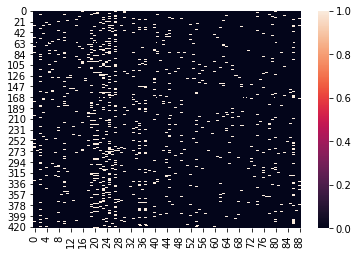

In [15]:
impl = expl.copy()
impl[expl.nonzero()] = 1
train_i, test_i = train_test_split.train_val_split(impl)
sns.heatmap(impl)
model = esbmr2(prior_u = 'DP', prior_i = 'GN', components = 5, gamma = 0.475, beta = 0.1, sigma = 0.575, alpha_urn_u = 0.5, a = 0.2, b = 5)
model.fit(train_i, 100)

In [17]:
model.co_clustering_matrices()

## Community detection
### 1. Carte
Ciascun cluster è caratterizzato da diversi valori di interazione con i vari cluster dei merchant.

La stima basata su KMeans è leggermente discordante poiché individua meno cluster.

In [29]:
# mod2.KMeans_estimator(method_u = "silhouette", method_i = "silhouette") # computes the KMeans estimator

In [19]:
# model.vi_estimator()
# np.unique(model.zu_est)
# model.zu_est_vi
np.unique(model.zu_est_kmeans)

array([0, 1, 2, 3], dtype=int32)

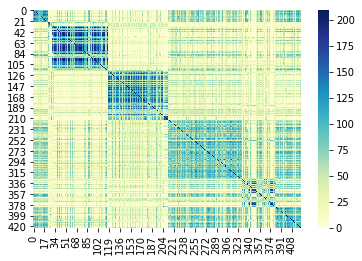

In [20]:
sns.heatmap(model.ccmatrix_u, cmap = 'YlGnBu')

### 2. Merchant
Il modello individua 12 cluster di merchant.

La stima basata su KMeans rileva 3 cluster. (!!!)

Rispetto alle carte, il clustering dei merchant appare più netto.

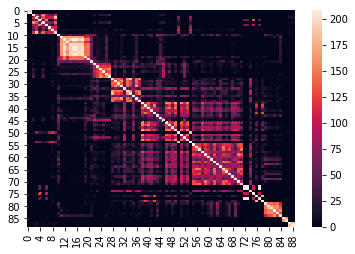

In [21]:
sns.heatmap(model.ccmatrix_i)

### Cluster at a glance

Due esempi simpatici: pure in assenza di covariate, vengono clusterizzati assieme "GARDEN LA FIORNITA" e "GIARDINANDO", così come "FARMACIA D AURIZIO" e "FARMACIA DAURIZIO", che in effetti in entrambi i casi corrispondono allo stesso esercente e allo stesso punto vendita.

In [32]:
id_car_clustered = np.vstack((id_car, model.zu_est)).T
merchant_clustered = np.vstack((nm_nome_cleaned, model.zi_est)).T
merchant_clustered[merchant_clustered[:,1] == 9]

array([['GARDEN LA FIORITA', 9],
       ['GIARDINANDO', 9]], dtype=object)

In [33]:
id_car_clustered = np.vstack((id_car, model.zu_est)).T
merchant_clustered = np.vstack((nm_nome_cleaned, model.zi_est)).T
merchant_clustered[merchant_clustered[:,1] == 0]

array([['FARMACIA D AURIZIO', 0],
       ['FARMACIA DAURIZIO', 0]], dtype=object)

Lo stimatore dei clsuter basato su K-Means, curiosamente, custerizza insieme tutte le farmacie.

In [52]:
id_car_clustered = np.vstack((id_car, model.zu_est_kmeans)).T
merchant_clustered = np.vstack((nm_nome_cleaned, model.zi_est_kmeans)).T
merchant_clustered[merchant_clustered[:,1] == 6]

array([['AGRIFARMA', 6],
       ['ARCAPLANET', 6],
       ['BUFFETTI', 6],
       ['CANEGATTO', 6],
       ['FARMACIA ADRIATICA', 6],
       ['FARMACIA CARLINI', 6],
       ['FARMACIA D AURIZIO', 6],
       ['FARMACIA DAURIZIO', 6],
       ['FARMACIA LAURI', 6],
       ['FARMACIA OLIVIERI', 6],
       ['FARMACIA ROSINI', 6],
       ['FARMACIA TOMASSINI', 6],
       ['FARMACIE ANGELINI DI', 6],
       ['GARDEN LA FIORITA', 6],
       ['GIARDINANDO', 6],
       ['GIOCHERIA', 6],
       ['KIKO', 6],
       ['MEDICAL SAN', 6],
       ['SPIPERCART', 6],
       ['TIGOTA', 6]], dtype=object)

## Matrice di interazione carte-merchant
- L'heatmap riporta il grado di interazione normalizzato tra cluster di user e cluster di item.
- Le prediction si baseranno su tali valori

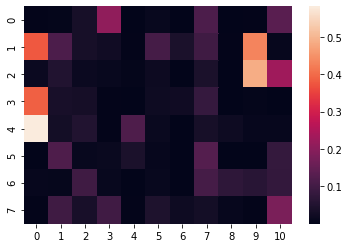

In [53]:
sns.heatmap(model.theta_est)

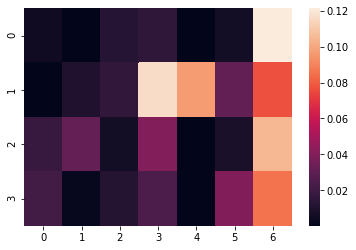

In [54]:
sns.heatmap(model.theta_est_kmeans)

### Accuracy vs. Novelty
L'accuracy del modello "risente" della struttura a blocchi, che tuttavia si rivela utile per raccomandare novità agli utenti.

$Accuracy = \frac{\text{# correct predictions}}{\text{# total predictions}}$

In [70]:
pred_i = pred_i / pred_i.max()

## Generare raccomandazioni
- La funzione <b>block recommend</b> ritorna i merchant suddivisi per cluster.

In [43]:
# u1, u2 = 0,10
# print(f" - Recommendations for user {u1}: ",model.block_recommend([0],5))
# print(f" - Recommendations for user {u2}: ",model.block_recommend([10],5))

## Confronto con un'euristica: memory-based collaborative filtering
Un memory-based collaborative filtering è un algoritmo di raccomandazione basato unicamente su logiche algoritmiche. Non vi è dunque alcun fitting di modello. Il CF implementato è un CF user-based: le raccomandazioni per ciascuna carta sono la media aritmetica dei movimenti delle 10 carte più simili. 

In [55]:
cf = CF()
cf.fit(train_i, 10)

array([[0.1, 0.2, 0.2, ..., 0.4, 0. , 0. ],
       [0.1, 0.2, 0.1, ..., 0.3, 0. , 0. ],
       [0.1, 0.1, 0.2, ..., 0.5, 0. , 0.1],
       ...,
       [0.1, 0.1, 0.2, ..., 0.3, 0. , 0.1],
       [0.1, 0.2, 0.1, ..., 0.4, 0. , 0. ],
       [0.1, 0.2, 0.2, ..., 0.3, 0. , 0.2]])

## Confronto con un modello concorrente: Hierarchical Poisson Factorization (HPF)
HPF è un latent feature model: al contrario dell'ESBMR, individua un vettore di feature per ciascuna carta e per ciascun merchant. Ciò si traduce in una elevata complessità modellistica, che limita le possibilità di fare inferenza dal modello.

Per i nostri dati, HPF genera 35890 parametri. ESBMR appena 104! Nonstante ciò, i due modelli hanno performance comparabili.

In [56]:
hpf = hpf_vi()
hpf.fit(train_i, 10, valid = test_i)

/home/ec2-user/SageMaker/dst-merchant-recommendation/hpf_vi.py:189: RuntimeWarning:

divide by zero encountered in log



Iteration 1 completed. Log-likelihood: -4711.55228871756
Iteration 2 completed. Log-likelihood: -3381.3558043805274
Iteration 3 completed. Log-likelihood: -3215.9405503631506
Iteration 4 completed. Log-likelihood: -3061.4095155097175
Iteration 5 completed. Log-likelihood: -2942.493148073184
Iteration 6 completed. Log-likelihood: -2861.0896668572877
Iteration 7 completed. Log-likelihood: -2806.1513396580854
Iteration 8 completed. Log-likelihood: -2768.958982935383
Iteration 9 completed. Log-likelihood: -2741.59882982959
Iteration 10 completed. Log-likelihood: -2720.5875499566173
Stopped after 2.062 seconds, 10 iterations. Log-likelihood: -2720.5875499566173.


## Performance metrics
1. Mean squared Error (MSE): in-sample and out-of-sample
2. Accuracy score
3. Sensitivity
3. Area under the ROC curve (AUC) - <i> for implicit feedback only </i>
4. Precision-at-z
5. Recall-at-z

In [66]:
pred_i_mode, pred_i_kmeans = model.predict(test_i)

### 1. Mean Squared Error

In [72]:
reload(scoring)
scoring.mse(train_i, test_i, pred_i_mode)

0.04940342862531831

### Random predictor

In [73]:
pred_rand = np.random.randn(test.shape[0], test.shape[1])

## AUC: confronto con le baseline

In [80]:
reload(scoring)
print(f"Score for CF: {scoring.roc_auc(train_i, test_i, cf.pred)}")
print(f"Score for ESBMR (mode): {scoring.roc_auc(train_i, test_i, pred_i_mode)}")
print(f"Score for ESBMR (kmeans): {scoring.roc_auc(train_i, test_i, pred_i_kmeans)}")
print(f"Score for HPF: {scoring.roc_auc(train_i, test_i, hpf.predicted)}")
print(f"Score for random: {scoring.roc_auc(train_i, test_i, pred_rand)}")

Score for CF: 0.647515570934256
Score for ESBMR (mode): 0.6845716938138239
Score for ESBMR (kmeans): 0.7062729344248461
Score for HPF: 0.7255282302303991
Score for random: 0.5143492277829352


### Distribuzione dell'AUC al variare del test set per i quattro recommender system
ei grafici, in ordine: CF, ESBMR, HPF, random

(array([ 1.,  3.,  4.,  5.,  6., 12.,  5.,  7.,  3.,  2.,  1.,  1.]),
 array([0.484477  , 0.48586298, 0.48724897, 0.48863495, 0.49002093,
        0.49140691, 0.49279289, 0.49417888, 0.49556486, 0.49695084,
        0.49833682, 0.4997228 , 0.50110879]),
 <a list of 12 Patch objects>)

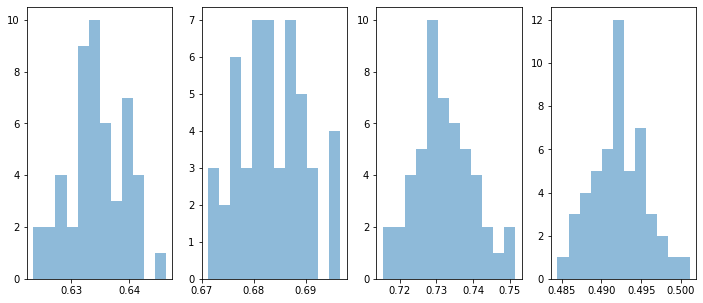

In [121]:
fig, ax = plt.subplots(figsize = (12,5), ncols = 4)

ax[0].hist([scoring.roc_auc(train_i,test_i, cf.pred) for i in range(50)], bins = 12, alpha = 0.5)
ax[1].hist([scoring.roc_auc(train_i,test_i, pred_i) for i in range(50)], bins = 12, alpha = 0.5)
ax[2].hist([scoring.roc_auc(train_i,test_i, hpf.predicted) for i in range(50)], bins = 12, alpha = 0.5)
ax[3].hist([scoring.roc_auc(train_i,test_i, pred_rand) for i in range(50)], bins = 12, alpha = 0.5)

### Mean Squared Error - comparazione

In [82]:
reload(scoring)
print(f"Score for CF: {scoring.mse(train_i, test_i, cf.pred)}")
print(f"Score for ESBMR (mode): {scoring.mse(train_i, test_i, pred_i_mode)}")
print(f"Score for ESBMR (kmeans): {scoring.mse(train_i, test_i, pred_i_kmeans)}")
print(f"Score for HPF: {scoring.mse(train_i, test_i, hpf.predicted)}")
print(f"Score for random: {scoring.mse(train_i, test_i, pred_rand)}")

Score for CF: 0.059148657498362824
Score for ESBMR (mode): 0.04904547045586311
Score for ESBMR (kmeans): 0.0496019465595142
Score for HPF: 0.049476748873337306
Score for random: 1.0816923998928618


In [86]:
model.recall_at_z(test_i, pred_i_mode, threshold = 0.1)

0.19922879177377892

Recall-at-z is much higher than precision-at-z: as expected, since the model is based on a block structure, 
it will suggest many items that are in line with the preference of the user, but that the user never consumed.
Hence, on the one hand, we get a relatively low precision-at-z.
On the other hand, a high recall confirms that the model detects a high proportion of relevant items on the total.

## Aggiunta di informazioni nodali come covariate

In [130]:
!jupyter nbconvert ESBMR_analysis_implicit.ipynb --to html --no-input

[NbConvertApp] Converting notebook ESBMR_analysis_implicit.ipynb to html
[NbConvertApp] Writing 559231 bytes to ESBMR_analysis_implicit.html
